In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import xarray as xr
import fnmatch
import numpy as np
import os
from surgeNN.io import load_predictand,load_predictors
from surgeNN.preprocessing import get_denseloss_weights,get_splitted_predictand_and_predictor_data,stack_predictors_for_lstm, normalize_predictand_splits, normalize_predictor_splits,standardize_predictand_splits, standardize_predictor_splits
from surgeNN.models import build_LSTM_stacked
from surgeNN.models import build_LSTM_stacked
from surgeNN.losses import gevl,mse_exp_negexp
from surgeNN.utils import create_batched_sequenced_datasets, compute_statistics_for_output_ds, generate_windowed_finite_numpy_input,rmse
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from target_relevance import TargetRelevance #if starting with a clean environment, first, in terminal, do->'mamba install kdepy'

import gc #callback to clean up garbage after each epoch, not sure if needed (usage: callbacks = [GC_Callback()])
class GC_Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

2024-07-24 07:50:59.433901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ImportError: cannot import name 'mse_exp_negexp' from 'surgeNN.losses' (/home/jovyan/test_surge_models/surgeNN/surgeNN/losses.py)

Configure the script:

In [2]:
tgs        = ['barcelona-bar-esp-cmems.csv','den_helder-denhdr-nld-rws.csv', 'brest-822a-fra-uhslc.csv', 
            'immingham-imm-gbr-bodc.csv','stavanger-svg-nor-nhs.csv'] #tide gauges to process
tgs = ['den_helder-denhdr-nld-rws.csv']
temp_freq = 6 # [hours] temporal frequency to use
n_cells   = 5 #n x n grid cells around tide gauge of predictor data to use

var_names = ['msl','u10','v10','w'] #variables to use
loss_function = 'DenseLoss_mse' # any default loss function or 'DenseLoss_[default loss function]' or 'gevl'
alpha = 5 #DenseLoss alpha parameter, vary between 1-5? (not used if not using loss function)
gamma = 3 #gevl gamma parameter, vary between 1-3? (not used if not using loss function)

input_dir  = '/home/jovyan/test_surge_models/input/' #directory with predictor & predictand data
output_dir = '/home/jovyan/test_surge_models/results/lstm_loss_function_tests/' #where to store the results

n_runs = 1 #how many iterations with different hyperparameter combinations to run
n_epochs = 75 #how many training epochs
patience = 5 #early stopping patience
split_fractions = [.5,.25,.25] #train, test, val

#hyperparameters:
batch_size = np.array([128]).astype('int')
n_steps = np.array([5]).astype('int') #at and 12h or 24h or 36h before (to-do: also use timesteps after?)
n_lstm = np.array([2]).astype('int')
n_lstm_units = np.array([48]).astype('int')
n_dense = np.array([2]).astype('int')
n_dense_units = np.array([48]).astype('int')
dropout = np.array([0.1])
lrs = np.array([1e-5])
l1s = np.array([0.02])

possible_params = [batch_size, n_steps, n_lstm, n_lstm_units,
                    n_dense, n_dense_units, dropout, lrs, l1s]

n_combinations = np.prod(np.array([len(k) for k in possible_params])) #number of unique combinations possible

Determine loss function to use:

In [3]:
#determine loss function to use
use_dl = False
dl_pos_only = False

if loss_function.split('_')[0] == 'DenseLoss':
    use_dl = True
    dl_pos_only = False
    loss_function_ = loss_function.split('_')[-1]
                                
elif loss_function.split('_')[0] == 'DenseLossPos':
    use_dl = True
    dl_pos_only = True
    loss_function_ = loss_function.split('_')[-1]  
    
elif loss_function == 'gevl':
    loss_function_ = gevl(gamma)
    #use_dl=True

elif loss_function =='exp':
    loss_function_ = mse_exp_negexp
else:
    loss_function_ = loss_function

Load in & preprocess data:

In [4]:
tg_lons = []
tg_lats = []

for tg in tqdm(tgs): #loop over TGs
    tf.keras.backend.clear_session() #clean up previous training session
    
    #load & process predictors
    predictors = load_predictors('/home/jovyan/test_surge_models/input/predictors_'+str(temp_freq)+'hourly',tg,n_cells) #open predictor xarray dataset
    predictors = predictors.sel(time=slice('1980','2016')) #2018 because of end year GTSM simulations that are used as benchmark
    
    #load & process predictands
    predictand = load_predictand('/home/jovyan/test_surge_models/input/t_tide_'+str(temp_freq)+'h_anoms_deseasoned_predictands',tg) #open predictand csv
    predictand = predictand.set_index('date').resample(str(temp_freq)+'h').fillna(method=None) #insert nans where timesteps are missing
    predictand = predictand.reset_index()[['surge','date','lon','lat']]

    predictand['surge'] = predictand['surge'].rolling(window=int(12/temp_freq+1),min_periods=int(12/temp_freq+1),center=True).mean() #crude way to filter out peaks due to uncorrected tides (Tiggeloven et al., 2021)
    predictand = predictand[(predictand['date']>=predictors.time.isel(time=0).values) & (predictand['date']<=predictors.time.isel(time=-1).values)]  # only use predictands in the period for which we also have predictor values, including at preceding timesteps
  
    #pre-generate input data for each n_steps (on which the input data depends)
    input_dict = {}
    for n in n_steps:
        
        #generate splits
        idx_train,idx_val,idx_test,x_train,x_val,x_test,y_train,y_val,y_test = get_splitted_predictand_and_predictor_data(predictand,predictors,split_fractions,n)
        #idx_train,idx_val,idx_test,x_train,x_val,x_test,y_train,y_val,y_test,y_train_mean,y_train_std = get_predictand_and_predictor_splits(predictand,predictors,split_ratios,n,var_names)
        
        #standardize the input based on the mean & sd of the train split
        y_train,y_val,y_test,y_train_mean,y_train_sd = standardize_predictand_splits(y_train,y_val,y_test,output_transform = True)
        x_train,x_val,x_test = standardize_predictor_splits(x_train,x_val,x_test)
        '''
        y_train,y_val,y_test,y_train_mean,y_train_sd = normalize_predictand_splits(y_train,y_val,y_test,output_transform = True)
        x_train,x_val,x_test = normalize_predictor_splits(x_train,x_val,x_test)
        '''
        
        x_train, x_val, x_test = [stack_predictors_for_lstm(k,var_names) for k in [x_train,x_val,x_test]] #stack all predictor variables at each grid cell for LSTM input
        w_train,w_val = [get_denseloss_weights(k, alpha = alpha ) for k in [y_train,y_val]] #generate DenseLoss weights for train & val splits                             

        #put all input into a dictionary to access later
        input_dict[n] = [idx_train,idx_val,idx_test, x_train,x_val,x_test,
                         y_train,y_val,y_test, y_train_mean,y_train_sd,
                         w_train,w_val]
    
    #train & evaluate models n_runs times:
    all_params = [] #list of hyperparameters
    tg_datasets = [] #list to store output

    for i in tqdm(np.arange(n_runs if n_runs < n_combinations else n_combinations)): #loop over hyperparameter combinations
        
        #randomly select unique combinations of hyperparameters
        k=True 
        while k == True:
            these_params = [np.random.choice(k) for k in possible_params] 
            if these_params in all_params:
                k = True
            else:
                k = False
                all_params.append(these_params) #keep track of hyperparameter combinations

        this_batch_size,this_n_steps,this_n_lstm,this_n_lstm_units,this_n_dense,this_n_dense_units,this_dropout,this_lr,this_l2 = these_params
        
        #load data for this tide gauge and n_steps
        idx_train,idx_val,idx_test,x_train,x_val,x_test,y_train,y_val,y_test,y_train_mean,y_train_sd,w_train,w_val = input_dict[this_n_steps] #fetch input data for this_n_steps
        
        #get values & timestamps of observations to compare predictions with
        t_train = predictand['date'].values[idx_train][np.isfinite(y_train)]
        t_val = predictand['date'].values[idx_val][np.isfinite(y_val)]
        t_test = predictand['date'].values[idx_test][np.isfinite(y_test)]

        #get windowed predictors & filter rows with nan observations from inputs (for tensorflow pipeline (to handle out-of-memory windowed predictors) see code below)
        x_train,y_train,w_train = generate_windowed_finite_numpy_input(x_train,y_train,this_n_steps,w_train)
        x_val,y_val,w_val = generate_windowed_finite_numpy_input(x_val,y_val,this_n_steps,w_val)
        x_test,y_test = generate_windowed_finite_numpy_input(x_test,y_test,this_n_steps)
        
        o_train,o_val,o_test = [y_train_sd * k + y_train_mean for k in [y_train,y_val,y_test]] #back-transform observations
        '''
        o_train,o_val,o_test = [(y_train_sd-y_train_mean) * k + y_train_mean for k in [y_train,y_val,y_test]] #back-transform observations
        '''
        #build LSTM model with current hyperparameters:
        model = build_LSTM_stacked(this_n_lstm, this_n_dense, 
                                  (np.ones(this_n_lstm)*this_n_lstm_units).astype(int), 
                                  (np.ones(this_n_dense)*this_n_dense_units).astype(int), 
                                   this_n_steps,int(n_cells/0.25),int(n_cells/0.25),len(var_names), 'lstm0',
                                   this_dropout, this_lr, loss_function_,l2=this_l2)

        #train model:
        if use_dl: #if using weights
            history = model.fit(x=x_train,y=y_train,epochs=n_epochs,batch_size=this_batch_size,sample_weight=w_train,validation_data=(x_val,y_val,w_val),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience,
                                restore_best_weights=True),GC_Callback()],verbose=0) #with numpy arrays input
        else: #else
            history = model.fit(x=x_train,y=y_train,epochs=n_epochs,batch_size=this_batch_size,validation_data=(x_val,y_val),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience,
                                restore_best_weights=True),GC_Callback()],verbose=0) #with numpy arrays input

        #make predictions & back-transform
        
        yhat_train = model.predict(x_train,verbose=0).flatten()*y_train_sd + y_train_mean
        yhat_val = model.predict(x_val,verbose=0).flatten()*y_train_sd + y_train_mean
        yhat_test = model.predict(x_test,verbose=0).flatten()*y_train_sd + y_train_mean
        '''
        yhat_train = model.predict(x_train,verbose=0).flatten()*(y_train_sd-y_train_mean) + y_train_mean
        yhat_val = model.predict(x_val,verbose=0).flatten()*(y_train_sd-y_train_mean) + y_train_mean
        yhat_test = model.predict(x_test,verbose=0).flatten()*(y_train_sd-y_train_mean) + y_train_mean
        '''
        #store into xr dataset
        ds_train = xr.Dataset(data_vars=dict(o=(["time"], o_train),yhat=(["time"], yhat_train),hyperparameters=(['p'],these_params),),
        coords=dict(time=t_train,p=['batch_size', 'n_steps', 'n_lstm', 'n_lstm_units','n_dense', 'n_dense_units', 'dropout', 'lr', 'l2'],),
        attrs=dict(description="LSTM - neural network prediction performance.",loss_function=loss_function),)
        
        ds_val = xr.Dataset(data_vars=dict(o=(["time"], o_val),yhat=(["time"], yhat_val),hyperparameters=(['p'],these_params),),
        coords=dict(time=t_val,p=['batch_size', 'n_steps', 'n_lstm', 'n_lstm_units','n_dense', 'n_dense_units', 'dropout', 'lr', 'l2'],),
        attrs=dict(description="LSTM - neural network prediction performance.",loss_function=loss_function),)

        ds_test = xr.Dataset(data_vars=dict(o=(["time"], o_test),yhat=(["time"], yhat_test),hyperparameters=(['p'],these_params),),
        coords=dict(time=t_test,p=['batch_size', 'n_steps', 'n_lstm', 'n_lstm_units','n_dense', 'n_dense_units', 'dropout', 'lr', 'l2'],),
        attrs=dict(description="LSTM - neural network prediction performance.",loss_function=loss_function),)
        
        ds_i = xr.concat((ds_train,ds_val,ds_test),dim='split',coords='different')
        ds_i = ds_i.assign_coords(split = ['train','val','test'])
        
        loss = np.nan*np.zeros(n_epochs)
        val_loss = np.nan*np.zeros(n_epochs)
        
        loss[0:len(history.history['loss'])] = history.history['loss']
        val_loss[0:len(history.history['val_loss'])] = history.history['val_loss']
        
        ds_i['loss'] = (['e'],loss)
        ds_i['val_loss'] = (['e'],val_loss)
        
        tg_datasets.append(ds_i)
        
        tf.keras.backend.clear_session()
        del model, history, ds_i, x_train, x_val, x_test# z_train, z_val, z_test
        
    #concatenate across runs & compute statistics
    out_ds = xr.concat(tg_datasets,dim='i',coords='different')
    out_ds = compute_statistics_for_output_ds(out_ds,[.95,.98,.99])
  
    out_ds = out_ds.assign_coords(tg = np.array([tg]))
    
    if use_dl:
        out_ds = out_ds.assign_coords(alpha = np.array([alpha]))

    out_ds = out_ds.assign_coords(lon = ('tg',np.array([predictand['lon'].values[0]])))
    out_ds = out_ds.assign_coords(lat = ('tg',np.array([predictand['lat'].values[0]])))
    
    out_ds.attrs['temp_freq'] = temp_freq
    out_ds.attrs['n_cells'] = n_cells
    out_ds.attrs['n_epochs'] = n_epochs
    

    #out_ds.to_netcdf(os.path.join(output_dir,'lstm_lossfunc_test_'+tg.replace('.csv','')+'_'+loss_function.replace('DenseLoss','DenseLoss'+str(alpha)).replace('gevl','gevl'+str(gamma))+'.nc'),mode='w')

  0%|          | 0/1 [00:00<?, ?it/s]2024-07-23 13:29:17.273368: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 841344000 exceeds 10% of free system memory.
2024-07-23 13:29:24.207336: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 841344000 exceeds 10% of free system memory.
2024-07-23 13:30:57.623215: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 841344000 exceeds 10% of free system memory.
2024-07-23 13:30:58.695748: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 841344000 exceeds 10% of free system memory.

100%|██████████| 1/1 [01:56<00:00, 116.09s/it]


In [5]:
np.exp(5/5)


2.718281828459045

In [6]:
np.exp(1/5)

1.2214027581601699

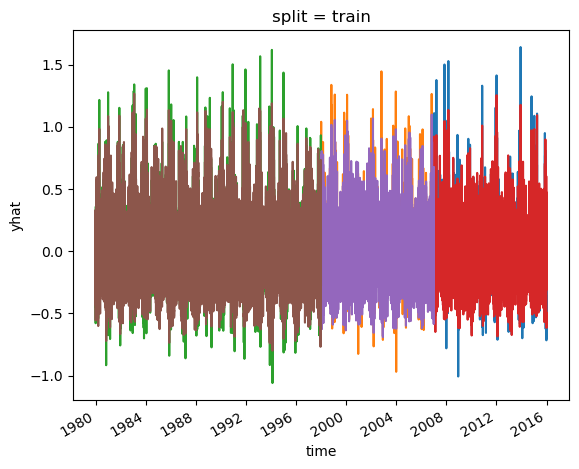

In [7]:
out_ds.o.sel(split='test').plot()
out_ds.o.sel(split='val').plot()
out_ds.o.sel(split='train').plot()

out_ds.yhat.sel(split='test').plot()
out_ds.yhat.sel(split='val').plot()
out_ds.yhat.sel(split='train').plot()

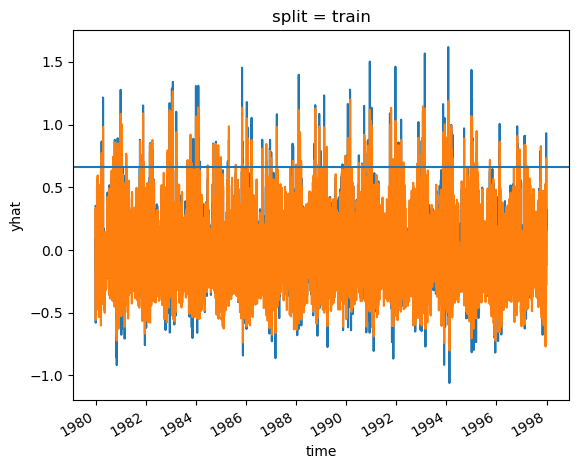

In [8]:
plt.figure()
#out_ds.o.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
#out_ds.yhat.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

#out_ds.o.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
#out_ds.yhat.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

out_ds.o.sel(split='train').isel(i=0).plot()
out_ds.yhat.sel(split='train').isel(i=0).plot()
plt.axhline(y=out_ds.yhat.sel(split='train').isel(i=0).quantile(.98,dim='time').values)

(-2.0, 2.0)

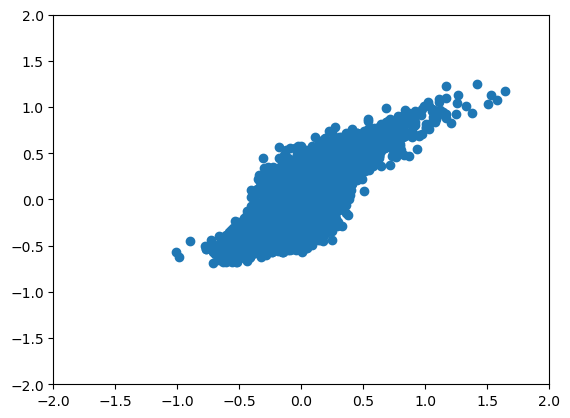

In [9]:
plt.scatter(out_ds.o.sel(split='test').isel(i=0),out_ds.yhat.sel(split='test').isel(i=0))
plt.ylim([-2,2])
plt.xlim([-2,2])

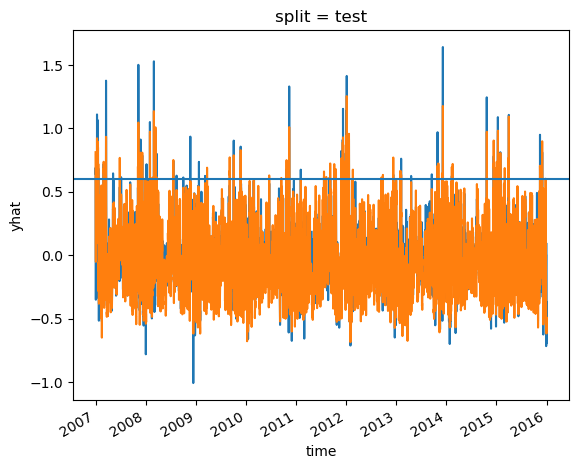

In [ ]:
plt.figure()
#out_ds.o.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
#out_ds.yhat.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

#out_ds.o.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
#out_ds.yhat.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

out_ds.o.sel(split='test').isel(i=0).plot()
out_ds.yhat.sel(split='test').isel(i=0).plot()
plt.axhline(y=out_ds.yhat.sel(split='test').isel(i=0).quantile(.98,dim='time').values)

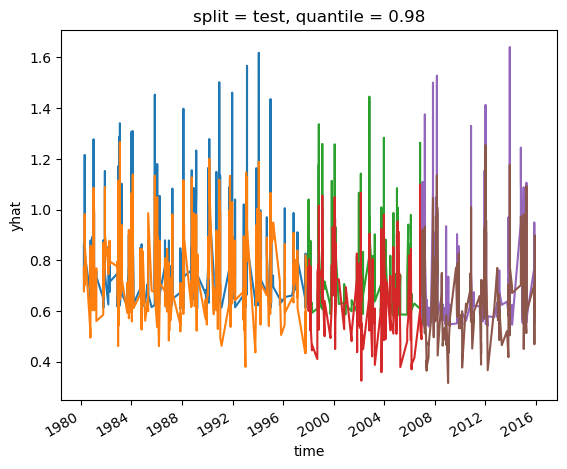

In [ ]:
plt.figure()
out_ds.o.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
out_ds.yhat.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

out_ds.o.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
out_ds.yhat.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

out_ds.o.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
out_ds.yhat.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.98,dim='time'),drop=True).plot()


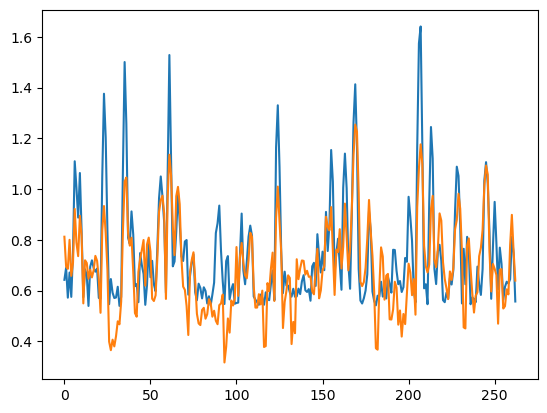

In [ ]:
plt.figure()
plt.plot(out_ds.o.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.98,dim='time'),drop=True).values)
plt.plot(out_ds.yhat.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.98,dim='time'),drop=True).values)


In [17]:
out_ds.rmse_extremes.sel(split='test')

<xarray.DataArray 'rmse_extremes' (i: 1, quantile: 3)>
array([[0.13046875, 0.14627086, 0.17575544]])
Coordinates:
    split     <U5 'test'
  * quantile  (quantile) float64 0.95 0.98 0.99
Dimensions without coordinates: i

In [18]:
out_ds.r_extremes.sel(split='test')

<xarray.DataArray 'r_extremes' (i: 1, quantile: 3)>
array([[0.76944061, 0.76073639, 0.72139865]])
Coordinates:
    split     <U5 'test'
  * quantile  (quantile) float64 0.95 0.98 0.99
Dimensions without coordinates: i

In [22]:
threshold_pct=99
threshold_value = out_ds.o.isel(i=0).sel(split='test').quantile(.99,dim='time').values

y_true = out_ds.o.isel(i=0).sel(split='test')#.dropna(dim='time')

surge_codec = xr.open_dataset('/home/jovyan/test_surge_models/CoDEC_ERA5_at_gesla3_tgs_eu_hourly_anoms.nc')
surge_codec = surge_codec.sel(tg=tg).sel(time=out_ds.time.where(np.isfinite(y_true),drop=True))
surge_codec['surge'] = surge_codec['surge'].rolling(time=3,min_periods=1,center=True).mean()
#surge_codec['surge'] = (surge_codec['surge'] - surge_codec['surge'].mean(dim='time'))/surge_codec['surge'].std(dim='time',ddof=0) #normalize
#surge_codec_test=surge_codec.surge.values[np.isfinite(y_true)]
#y_true = y_true[np.isfinite(y_true)]
y_true = out_ds.o.isel(i=0).sel(split='test').dropna(dim='time').values
#surge_codec_test = surge_codec.sel(tg=tg).sel(time=predictand['date'].values[idx_test][n_steps-1::]).surge.values #select test timesteps
surge_codec_test_exceedances = (surge_codec.surge.values>=threshold_value).flatten() #find where exceeding threshold
y_true_exceedances = (y_true>=threshold_value)
print('---CoDEC---')
print('bulk correlation r='+str(np.corrcoef(surge_codec.surge.values,y_true)[0][1]))
print('bulk RMSE='+str(rmse(surge_codec.surge.values,y_true)))
print('Confusion matrix exceedances above {0}th percentile:'.format(threshold_pct))
print(confusion_matrix(y_true_exceedances,surge_codec_test_exceedances))

print('Correlation at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('r=' + str(np.corrcoef(surge_codec.surge.values[y_true_exceedances],y_true[y_true_exceedances])[0][1]))
print('RMSE at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('RMSE=' + str(rmse(surge_codec.surge.values[y_true_exceedances],y_true[y_true_exceedances])))


---CoDEC---
bulk correlation r=0.9183655132707584
bulk RMSE=0.09051889229843978
Confusion matrix exceedances above 99th percentile:
[[12964    48]
 [   20   112]]
Correlation at timesteps where observations above 99th percentile:
r=0.8637447691638647
RMSE at timesteps where observations above 99th percentile:
RMSE=0.11029440698707525


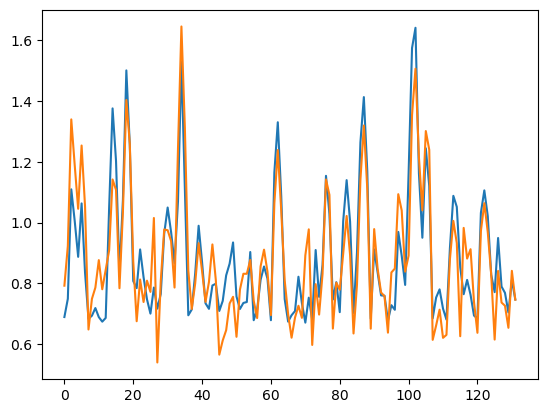

In [24]:

plt.plot(y_true[y_true_exceedances])
plt.plot(surge_codec.surge.values[y_true_exceedances])

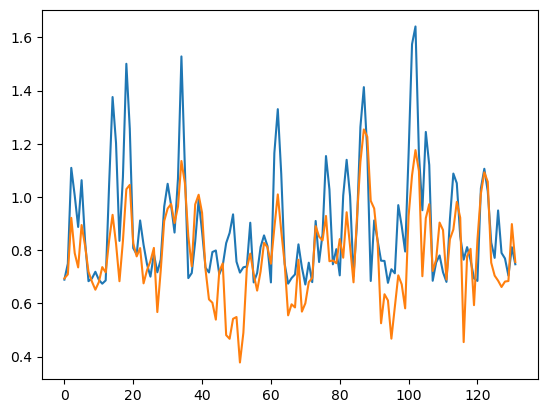

In [23]:
plt.plot(out_ds.o.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.99,dim='time'),drop=True).values)
plt.plot(out_ds.yhat.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.99,dim='time'),drop=True).values)


In [20]:
out_ds.r_bulk

<xarray.DataArray 'r_bulk' (i: 1, split: 3)>
array([[0.70603564, 0.67384388, 0.6716272 ]])
Coordinates:
  * split    (split) <U5 'train' 'val' 'test'
Dimensions without coordinates: i

In [21]:
out_ds.o.quantile(.99,dim='time')

<xarray.DataArray 'o' (i: 1, split: 3)>
array([[0.2005901 , 0.20513289, 0.20433226]])
Coordinates:
  * split     (split) <U5 'train' 'val' 'test'
    quantile  float64 0.99
Dimensions without coordinates: i

Tensorflow pipeline:

```python
#get values & timestamps of observations to compare predictions with
o_val = y_train_sd * y_val[np.isfinite(y_val)][0:int(np.sum(np.isfinite(y_val))/batch_size)] + y_train_mean #back-transform observations val split
o_test = y_train_sd * y_test[np.isfinite(y_test)][0:int(np.sum(np.isfinite(y_val))/batch_size)] + y_train_mean #back-transform observations val split

t_val = predictand['date'].values[idx_val][np.isfinite(y_val)][0:int(np.sum(np.isfinite(y_val))/batch_size)]
t_test = predictand['date'].values[idx_test][np.isfinite(y_test)][0:int(np.sum(np.isfinite(y_val))/batch_size)]

#create windowed predictors, filter out timesteps with NaN observations & create batches:
if use_dl == False: #if not using weights
    z_train = create_batched_sequenced_datasets(x_train, y_train, this_n_steps, this_batch_size).cache() #cache() speeds up the training by loading in the data at epoch 0, but takes up a lot of memory
    z_val = create_batched_sequenced_datasets(x_val, y_val, this_n_steps, this_batch_size).cache()

    x_val_ds = z_val.map(lambda a, b : a) #unpack z_val for prediction

elif use_dl == True: #if using weights
    z_train = create_batched_sequenced_datasets(x_train, y_train, this_n_steps, this_batch_size, w_train).cache()
    z_val = create_batched_sequenced_datasets(x_val, y_val, this_n_steps, this_batch_size, w_val).cache()

    x_val_ds = z_val.map(lambda a, b, c: a) #unpack z_val for prediction

z_test = create_batched_sequenced_datasets(x_test, y_test, this_n_steps, this_batch_size) #to-do: z_test doesn't have to be batched?
x_test_ds = z_test.map(lambda a, b: a) #unpack z_test for prediction

history = model.fit(z_train,epochs=n_epochs,validation_data=z_val,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                            restore_best_weights=True)],verbose=0) #train model
            
#make predictions & back-transform
yhat_val = model.predict(x_val_ds,verbose=0).flatten()*y_train_sd + y_train_mean
yhat_test = model.predict(x_test_ds,verbose=0).flatten()*y_train_sd + y_train_mean
```